In [717]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pmdarima as pm
import plotly.express as px
import seaborn as sns

In [718]:
df = pd.read_csv("DailyDelhiClimateTrain.csv",parse_dates=['date'], index_col='date')

In [719]:
df.shape

(1462, 4)

In [720]:
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [721]:
df.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

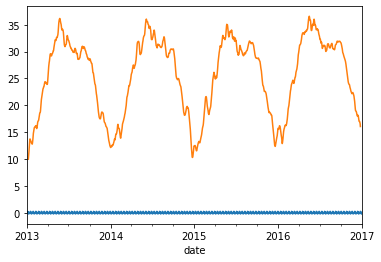

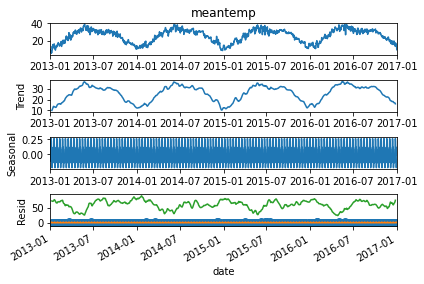

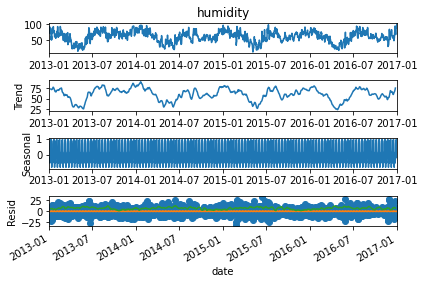

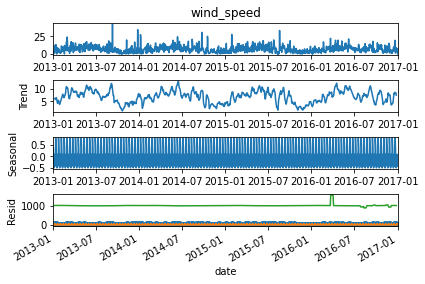

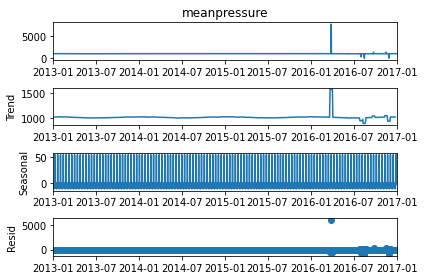

In [722]:
from statsmodels.tsa.seasonal import seasonal_decompose

for col in df.columns:
    result = seasonal_decompose(df[col], model = 'additive', period = 12)
    result.seasonal.plot()
    result.trend.plot()
    result.plot()

In [723]:
def adf(col):
    print("-------" + col + "-------")
    adf = adfuller(df.loc[:, col].values, autolag = 'AIC')
    print("ADF Statistic:", adf[0])
    print("p-value:", adf[1])
    print("n_lags:", adf[2])
    for key, value in adf[4].items():
        print("Critical values:", key, value)
    if(adf[1]<0.05):
        print("Stationary data")
    else:
        print("Non-stationary data") 

In [724]:
print(adf("meantemp"))

-------meantemp-------
ADF Statistic: -2.0210690559206728
p-value: 0.27741213723016056
n_lags: 10
Critical values: 1% -3.4348647527922824
Critical values: 5% -2.863533960720434
Critical values: 10% -2.567831568508802
Non-stationary data
None


In [725]:
df_differenced = df.diff().dropna()

In [726]:
# df['diff_meantemp'] = df['meantemp'].diff()
# df['diff_humidity'] = df['humidity'].diff()
# df['diff_meanpressure'] = df['meanpressure'].diff()

In [727]:
# adf("diff_meantemp")

In [728]:
# df.dropna(inplace = True)

In [729]:
# plt.plot(df.diff_meantemp)

In [730]:
train_len = int(0.8 * len(df))
df_train = df[:train_len]
df_test = df[train_len:]

In [731]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  18.41355619482598
BIC :  18.48596977995889
FPE :  99290087.66561523
HQIC:  18.440569373209296 

Lag Order = 2
AIC :  18.168999334323484
BIC :  18.299416219687995
FPE :  77749288.68800458
HQIC:  18.217651741357518 

Lag Order = 3
AIC :  18.005324447996752
BIC :  18.193809144466965
FPE :  66010629.38870007
HQIC:  18.075641633906173 

Lag Order = 4
AIC :  17.92889432090961
BIC :  18.17551145668262
FPE :  61153555.17916754
HQIC:  18.02090188368582 

Lag Order = 5
AIC :  17.881287997502355
BIC :  18.18610231839216
FPE :  58310690.17699017
HQIC:  17.995011583025168 

Lag Order = 6
AIC :  17.85756143526391
BIC :  18.220637804996255
FPE :  56943776.65895723
HQIC:  17.99302673742362 

Lag Order = 7
AIC :  17.839411367430987
BIC :  18.26081476793913
FPE :  55919992.97330475
HQIC:  17.99664412825081 

Lag Order = 8
AIC :  17.827033248833136
BIC :  18.306828780554593
FPE :  55232632.14893994
HQIC:  18.00605925859208 

Lag Order = 9
AIC :  17.81024791560417
BIC :  18.3485007977

c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [732]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,18.85,18.86,1.532e+08,18.85
1,18.41,18.48,9.892e+07,18.44
2,18.16,18.29,7.704e+07,18.21
3,18.00,18.18,6.534e+07,18.07
4,17.92,18.17*,6.050e+07,18.01
5,17.87,18.17,5.745e+07,17.98
6,17.84,18.21,5.602e+07,17.98*
7,17.82,18.24,5.492e+07,17.98
8,17.82,18.30,5.474e+07,18.00
9,17.80,18.34,5.378e+07,18.00


In [733]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 24, Apr, 2023
Time:                     14:52:36
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    18.1755
Nobs:                     1457.00    HQIC:                   18.0209
Log likelihood:          -21262.8    FPE:                6.11536e+07
AIC:                      17.9289    Det(Omega_mle):     5.83808e+07
--------------------------------------------------------------------
Results for equation meantemp
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.005702         0.042323            0.135           0.893
L1.meantemp            -0.180305         0.035316           -5.105           0.000
L1.humidity             0.006900         0.007409

In [734]:
from itertools import combinations

treshold = 0.05

# Check if the lags of a quantity help predict its current value 
for quant in df.columns:
    
    causality = model_fitted.test_causality(quant, quant, kind='f')

    if causality.pvalue < treshold:
        print('{} lags might Granger-cause its current value (NULL HP rejected - pval = {:.4f})'.format(quant, causality.pvalue))
        print('---')

causally_related = []
        
# Check if one quantity causes the other
for quantA, quantB in combinations(df.columns,2):
    
    bidirectional = [(quantA,quantB),(quantB,quantA)]
    
    for caused, causing in bidirectional:
    
        causality = model_fitted.test_causality(caused, causing, kind='f')

        if causality.pvalue < treshold:
            print('{} might Granger-cause {} (NULL HP rejected - pval = {:.4f})'.format(causing, caused, causality.pvalue))
            print('---')
            causally_related.append((causing, caused))

meantemp lags might Granger-cause its current value (NULL HP rejected - pval = 0.0000)
---
humidity lags might Granger-cause its current value (NULL HP rejected - pval = 0.0000)
---
wind_speed lags might Granger-cause its current value (NULL HP rejected - pval = 0.0000)
---
meanpressure lags might Granger-cause its current value (NULL HP rejected - pval = 0.0000)
---
meantemp might Granger-cause humidity (NULL HP rejected - pval = 0.0001)
---
meantemp might Granger-cause wind_speed (NULL HP rejected - pval = 0.0001)
---
meantemp might Granger-cause meanpressure (NULL HP rejected - pval = 0.0083)
---
humidity might Granger-cause wind_speed (NULL HP rejected - pval = 0.0000)
---


In [735]:
# df_test = pd.read_csv('DailyDelhiClimateTest.csv')

# df_test = df_test.set_index('date')
# df_test.index = pd.to_datetime(df_test.index)
# df_test = df_test.asfreq('D')

# df_test.tail()

In [736]:
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[-1.97929607, 19.8136646 ,  2.45217391,  1.33954451],
       [-1.14285714,  1.80952381,  0.26666667,  1.        ],
       [ 0.95739348, -2.66666667,  1.05833333, -1.8047619 ],
       [-5.05263158, 13.        , -7.325     , -0.1       ]])

In [738]:
fc = model_fitted.forecast(y=forecast_input, steps=8)
df_forecast = pd.DataFrame(fc, index=df.index[-8:], columns=df.columns + '_2d')
df_forecast

,meantemp_2d,humidity_2d,wind_speed_2d,meanpressure_2d
date,,,,
2016-12-25,1.360284,-7.502487,2.245633,-11.572952
2016-12-26,0.408151,-0.251759,0.823495,54.933516
2016-12-27,0.531223,-0.162452,-0.229730,-54.098058
2016-12-28,0.070712,0.015757,0.654842,-3.574008
2016-12-29,-0.311551,0.989097,-0.612480,9.740728
2016-12-30,-0.081224,-0.167863,0.105484,9.290414
2016-12-31,0.026075,-0.186400,-0.006792,5.263267
2017-01-01,0.052792,-0.093039,-0.054237,-12.289991


In [739]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [740]:
df.columns

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [741]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        

In [742]:
df_results.loc[:, ['meantemp_2d', 'humidity_2d', 'wind_speed_2d', 'meanpressure_2d',
       'meantemp_1d', 'meantemp_forecast', 'humidity_1d', 'humidity_forecast',
       'wind_speed_1d', 'wind_speed_forecast', 'meanpressure_1d',
       'meanpressure_forecast']]

,meantemp_2d,humidity_2d,wind_speed_2d,meanpressure_2d,meantemp_1d,meantemp_forecast,humidity_1d,humidity_forecast,wind_speed_1d,wind_speed_forecast,meanpressure_1d,meanpressure_forecast
date,,,,,,,,,,,,
2016-12-25,1.360284,-7.502487,2.245633,-11.572952,-0.514716,21.860284,-6.689987,59.310013,1.676883,7.951883,-8.447952,1005.864548
2016-12-26,0.408151,-0.251759,0.823495,54.933516,-0.106565,21.753719,-6.941746,52.368267,2.500378,10.452261,46.485563,1052.350111
2016-12-27,0.531223,-0.162452,-0.229730,-54.098058,0.424658,22.178377,-7.104198,45.264069,2.270648,12.722910,-7.612495,1044.737616
2016-12-28,0.070712,0.015757,0.654842,-3.574008,0.495370,22.673746,-7.088442,38.175627,2.925490,15.648400,-11.186503,1033.551113
2016-12-29,-0.311551,0.989097,-0.612480,9.740728,0.183818,22.857565,-6.099344,32.076283,2.313010,17.961410,-1.445774,1032.105339
2016-12-30,-0.081224,-0.167863,0.105484,9.290414,0.102594,22.960158,-6.267207,25.809076,2.418494,20.379903,7.844639,1039.949978
2016-12-31,0.026075,-0.186400,-0.006792,5.263267,0.128669,23.088828,-6.453607,19.355468,2.411702,22.791606,13.107906,1053.057884
2017-01-01,0.052792,-0.093039,-0.054237,-12.289991,0.181461,23.270289,-6.546646,12.808822,2.357465,25.149071,0.817914,1053.875798


In [743]:
df_results

,meantemp_2d,humidity_2d,wind_speed_2d,meanpressure_2d,meantemp_1d,meantemp_forecast,humidity_1d,humidity_forecast,wind_speed_1d,wind_speed_forecast,meanpressure_1d,meanpressure_forecast
date,,,,,,,,,,,,
2016-12-25,1.360284,-7.502487,2.245633,-11.572952,-0.514716,21.860284,-6.689987,59.310013,1.676883,7.951883,-8.447952,1005.864548
2016-12-26,0.408151,-0.251759,0.823495,54.933516,-0.106565,21.753719,-6.941746,52.368267,2.500378,10.452261,46.485563,1052.350111
2016-12-27,0.531223,-0.162452,-0.229730,-54.098058,0.424658,22.178377,-7.104198,45.264069,2.270648,12.722910,-7.612495,1044.737616
2016-12-28,0.070712,0.015757,0.654842,-3.574008,0.495370,22.673746,-7.088442,38.175627,2.925490,15.648400,-11.186503,1033.551113
2016-12-29,-0.311551,0.989097,-0.612480,9.740728,0.183818,22.857565,-6.099344,32.076283,2.313010,17.961410,-1.445774,1032.105339
2016-12-30,-0.081224,-0.167863,0.105484,9.290414,0.102594,22.960158,-6.267207,25.809076,2.418494,20.379903,7.844639,1039.949978
2016-12-31,0.026075,-0.186400,-0.006792,5.263267,0.128669,23.088828,-6.453607,19.355468,2.411702,22.791606,13.107906,1053.057884
2017-01-01,0.052792,-0.093039,-0.054237,-12.289991,0.181461,23.270289,-6.546646,12.808822,2.357465,25.149071,0.817914,1053.875798


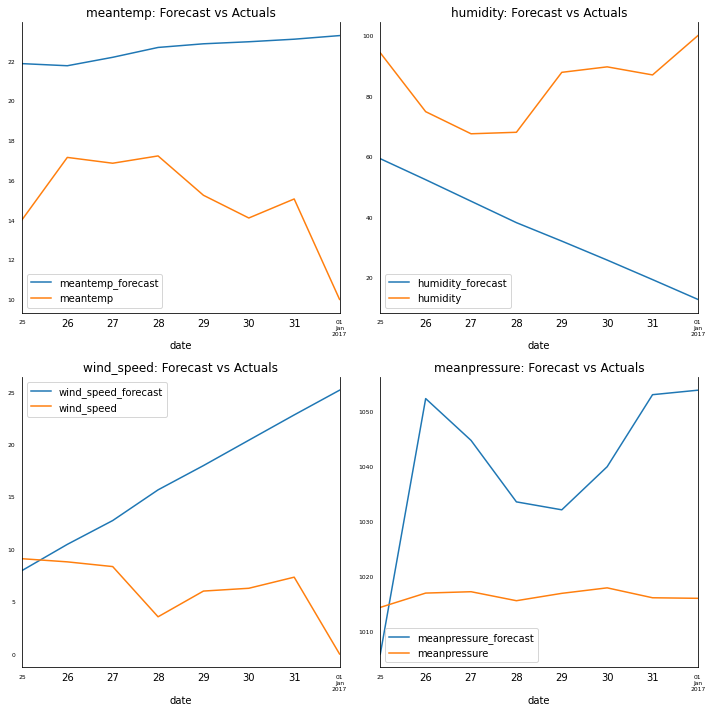

In [744]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-8:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();